<a href="https://colab.research.google.com/github/k4404c/tensorflow_workbook/blob/main/tensorflow4_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#transfer learning tf with the whole dataset

In [1]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir



--2024-05-14 02:53:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-14 02:53:31 (126 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-05-14 02:53:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.172.207, 108.177.112.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.172.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  54.4MB/s    in 39s     

2024-05-14 02:54:23 (40.0 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [3]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lasagna'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/greek_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images i

In [4]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    label_mode = "categorical",
                                                                    image_size = IMG_SIZE)
                                                                    #shuffle = False)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                    label_mode = "categorical",
                                                                    image_size = IMG_SIZE,
                                                                    shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [5]:
#Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best = True)

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential #NOTICE MODELS

data_aug = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.) not needed in eficienet
], name = "data_aug_layer")

In [7]:
#setup base model, freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Set up model architecture with trainable top layers

inputs = layers.Input(shape = (224,224,3), name = "input_layer")
x = data_aug(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "gloabal_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_10.class_names), activation = "softmax", name = "output_layer")(x)

model = tf.keras.Model(inputs,outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aug_layer (Sequential  (None, None, None, 3)     0         
 )                                                               
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 gloabal_avg_pool_layer (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [10]:
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

his_all_10 = model.fit(train_data_10,
                       epochs = 5,
                       #steps_per_epoch = len(train_data_10),
                       validation_data = test_data,
                       validation_steps = int(0.15 * len(test_data)),
                       callbacks = [checkpoint_callback]
                      )

Epoch 1/5
237/237 [==============================] - 128s 513ms/step - loss: 1.3536 - accuracy: 0.6638 - val_loss: 1.7834 - val_accuracy: 0.5410
Epoch 2/5
237/237 [==============================] - 120s 506ms/step - loss: 1.2241 - accuracy: 0.6968 - val_loss: 1.7858 - val_accuracy: 0.5326
Epoch 3/5
237/237 [==============================] - 119s 503ms/step - loss: 1.1319 - accuracy: 0.7185 - val_loss: 1.7791 - val_accuracy: 0.5405
Epoch 4/5
237/237 [==============================] - 117s 495ms/step - loss: 1.0538 - accuracy: 0.7405 - val_loss: 1.7563 - val_accuracy: 0.5373
Epoch 5/5
237/237 [==============================] - 119s 505ms/step - loss: 0.9972 - accuracy: 0.7547 - val_loss: 1.7749 - val_accuracy: 0.5384


In [11]:
model.evaluate(test_data)

790/790 [==============================] - 263s 333ms/step - loss: 1.5293 - accuracy: 0.5905


[1.5293009281158447, 0.5904554724693298]

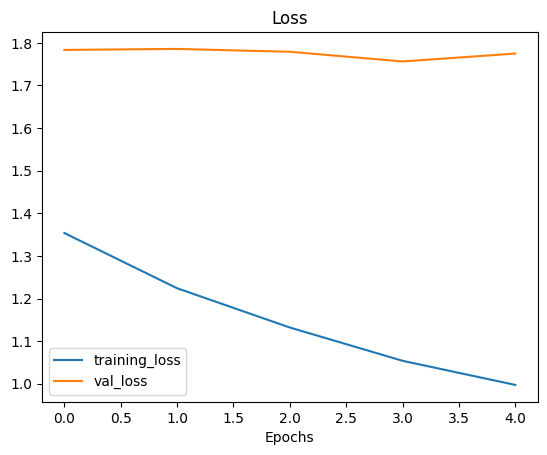

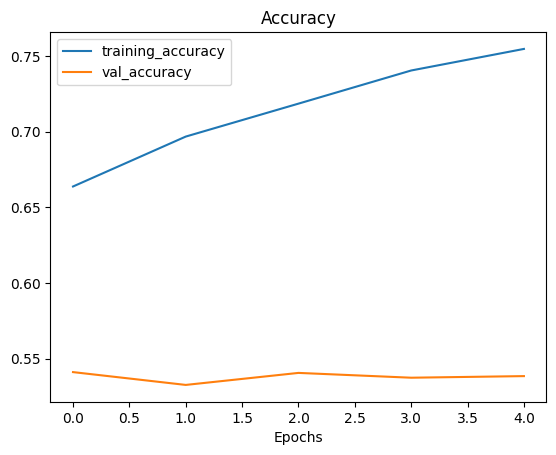

In [12]:
plot_loss_curves(his_all_10)

In [13]:
#fine tuning
#unfreeze all layers in base model
base_model.trainable = True
#refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [14]:
from typing_extensions import LiteralString
#recompile model
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["accuracy"])

for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_aug_layer True
efficientnetb0 True
gloabal_avg_pool_layer True
output_layer True


In [15]:
for layer_num, layer in enumerate(model.layers[2].layers):
  print(layer_num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [16]:
#fine tuning
fine_tune_epochs = 10

his_all_10_fine = model.fit(train_data_10,
                            epochs = fine_tune_epochs,
                            validation_data = test_data,
                            validation_steps = int(0.15*len(test_data)),
                            initial_epoch = his_all_10.epoch[-1])

Epoch 5/10
237/237 [==============================] - 130s 521ms/step - loss: 0.8495 - accuracy: 0.7739 - val_loss: 1.8028 - val_accuracy: 0.5474
Epoch 6/10
237/237 [==============================] - 121s 512ms/step - loss: 0.7577 - accuracy: 0.7950 - val_loss: 1.8041 - val_accuracy: 0.5482
Epoch 7/10
237/237 [==============================] - 122s 514ms/step - loss: 0.6697 - accuracy: 0.8206 - val_loss: 1.7426 - val_accuracy: 0.5601
Epoch 8/10
237/237 [==============================] - 120s 507ms/step - loss: 0.6270 - accuracy: 0.8305 - val_loss: 1.8438 - val_accuracy: 0.5432
Epoch 9/10
237/237 [==============================] - 119s 502ms/step - loss: 0.5956 - accuracy: 0.8368 - val_loss: 1.8489 - val_accuracy: 0.5516
Epoch 10/10
237/237 [==============================] - 120s 507ms/step - loss: 0.5484 - accuracy: 0.8531 - val_loss: 1.8703 - val_accuracy: 0.5429


In [17]:
model_10_fine = model.evaluate(test_data)

790/790 [==============================] - 263s 333ms/step - loss: 1.5868 - accuracy: 0.5987


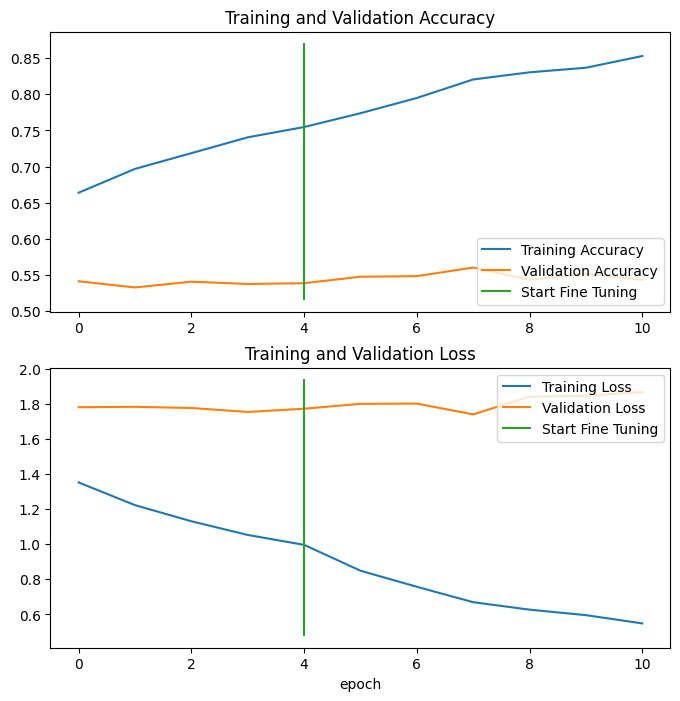

In [19]:
compare_historys(his_all_10,his_all_10_fine, initial_epochs=5)

In [20]:
#save and load our model
model.save("drive/MyDrive/tensorflow_course/101_food_class_10p_fine")

In [21]:
load_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_class_10p_fine")

In [22]:
loaded_model_results = load_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 258s 324ms/step - loss: 1.5868 - accuracy: 0.5987


[1.586769461631775, 0.5986534357070923]

In [23]:
model_10_fine

[1.586769461631775, 0.5986534357070923]

In [24]:
#Evaluating performance of model over all classes
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0])

--2024-05-14 04:17:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.207, 108.177.121.207, 142.251.171.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  36.7MB/s    in 1.2s    

2024-05-14 04:17:10 (36.7 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [25]:
mod_evals = model.evaluate(test_data)
mod_evals

790/790 [==============================] - 272s 342ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027210235595703, 0.6077623963356018]

In [26]:
#Making predictions with trained model
pred_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 259s 326ms/step


In [27]:
len(pred_probs)

25250

In [28]:
pred_probs.shape

(25250, 101)

In [29]:
pred_probs[:10]

array([[5.9541821e-02, 3.5742250e-06, 4.1377168e-02, ..., 1.4138677e-09,
        8.3531377e-05, 3.0897534e-03],
       [9.6401662e-01, 1.3753192e-09, 8.4780203e-04, ..., 5.4287197e-05,
        7.8362195e-12, 9.8465636e-10],
       [9.5925868e-01, 3.2533771e-05, 1.4867132e-03, ..., 7.1891475e-07,
        5.4396486e-07, 4.0275962e-05],
       ...,
       [4.7313324e-01, 1.2931275e-07, 1.4805654e-03, ..., 5.9750408e-04,
        6.6969056e-05, 2.3469327e-05],
       [4.4571627e-02, 4.7265465e-07, 1.2258537e-01, ..., 6.3498906e-06,
        7.5318271e-06, 3.6778837e-03],
       [7.2438961e-01, 1.9249733e-09, 5.2310988e-05, ..., 1.2291396e-03,
        1.5792806e-09, 9.6395750e-05]], dtype=float32)

In [30]:
#what does first prediction probability array look like:
pred_probs[0], len(pred_probs[0]), sum(pred_probs)

(array([5.95418215e-02, 3.57422505e-06, 4.13771681e-02, 1.06606746e-09,
        8.16151946e-09, 8.66399752e-09, 8.09271853e-07, 8.56525617e-07,
        1.98589551e-05, 8.09782932e-07, 3.17280979e-09, 9.86750365e-07,
        2.85323738e-04, 7.80496279e-10, 7.42300064e-04, 3.89164816e-05,
        6.47412253e-06, 2.49773962e-06, 3.78912337e-05, 2.06784037e-07,
        1.55385242e-05, 8.15068574e-07, 2.62304638e-06, 2.00107579e-07,
        8.38275184e-07, 5.42163343e-06, 3.73910984e-06, 1.31505313e-08,
        2.77613988e-03, 2.80517233e-05, 6.85627943e-10, 2.55748510e-05,
        1.66889105e-04, 7.64077135e-10, 4.04529477e-04, 1.31506823e-08,
        1.79575284e-06, 1.44482260e-06, 2.30629612e-02, 8.24670053e-07,
        8.53664915e-07, 1.71385284e-06, 7.05255616e-06, 1.84022682e-08,
        2.85536970e-07, 7.94832886e-06, 2.06818436e-06, 1.85251835e-07,
        3.36198305e-08, 3.15226382e-04, 1.04110004e-05, 8.54495738e-07,
        8.47418487e-01, 1.05555046e-05, 4.40942785e-07, 3.740445

In [31]:
#our model outputs a prediction probability array
print(f"Number of prediction probability for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like: {pred_probs[0]}")
print(f"The class with the highest predicted probabilty for sample 0: {pred_probs[0].argmax()}")

Number of prediction probability for sample 0: 101
What prediction probability sample 0 looks like: [5.95418215e-02 3.57422505e-06 4.13771681e-02 1.06606746e-09
 8.16151946e-09 8.66399752e-09 8.09271853e-07 8.56525617e-07
 1.98589551e-05 8.09782932e-07 3.17280979e-09 9.86750365e-07
 2.85323738e-04 7.80496279e-10 7.42300064e-04 3.89164816e-05
 6.47412253e-06 2.49773962e-06 3.78912337e-05 2.06784037e-07
 1.55385242e-05 8.15068574e-07 2.62304638e-06 2.00107579e-07
 8.38275184e-07 5.42163343e-06 3.73910984e-06 1.31505313e-08
 2.77613988e-03 2.80517233e-05 6.85627943e-10 2.55748510e-05
 1.66889105e-04 7.64077135e-10 4.04529477e-04 1.31506823e-08
 1.79575284e-06 1.44482260e-06 2.30629612e-02 8.24670053e-07
 8.53664915e-07 1.71385284e-06 7.05255616e-06 1.84022682e-08
 2.85536970e-07 7.94832886e-06 2.06818436e-06 1.85251835e-07
 3.36198305e-08 3.15226382e-04 1.04110004e-05 8.54495738e-07
 8.47418487e-01 1.05555046e-05 4.40942785e-07 3.74044575e-05
 3.53063915e-05 3.24892208e-05 6.73147370e-05 

In [32]:
test_data.class_names[52]

'gyoza'

In [33]:
pred_classes= pred_probs.argmax(axis=1)
pred_classes[:10]


array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [34]:
len(pred_classes)

25250

In [35]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #using argmax because it is hotencoded and 1 is at location of label
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [36]:
len(y_labels)

25250

In [38]:
#Evaluating models predictions
#lets us scikit-learns accuracy score function
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)
sklearn_accuracy

0.6077623762376237

In [39]:
import numpy as np
np.isclose(sklearn_accuracy, mod_evals[1])

True

In [43]:
#Lets make confusion matrix
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = test_data.class_names,
                      figsize = (100,100),
                      text_size = 10)

In [46]:
#Classification Report
from sklearn.metrics import classification_report
class_report = classification_report(y_true = y_labels,
                      y_pred = pred_classes
)
print(class_report)

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [47]:
#Get a dictionary of the model
class_report_dict = classification_report(y_true = y_labels,
                      y_pred = pred_classes,
                                          output_dict = True
)
class_report_dict



{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [54]:
class_names = test_data.class_names

#create empty dict
class_f1_scores = {}
for k, v in class_report_dict.items():
  if k == "accuracy":
    #stop once we get to accuracy key
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [55]:
#turn f1 scores into datafram
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending = False)
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

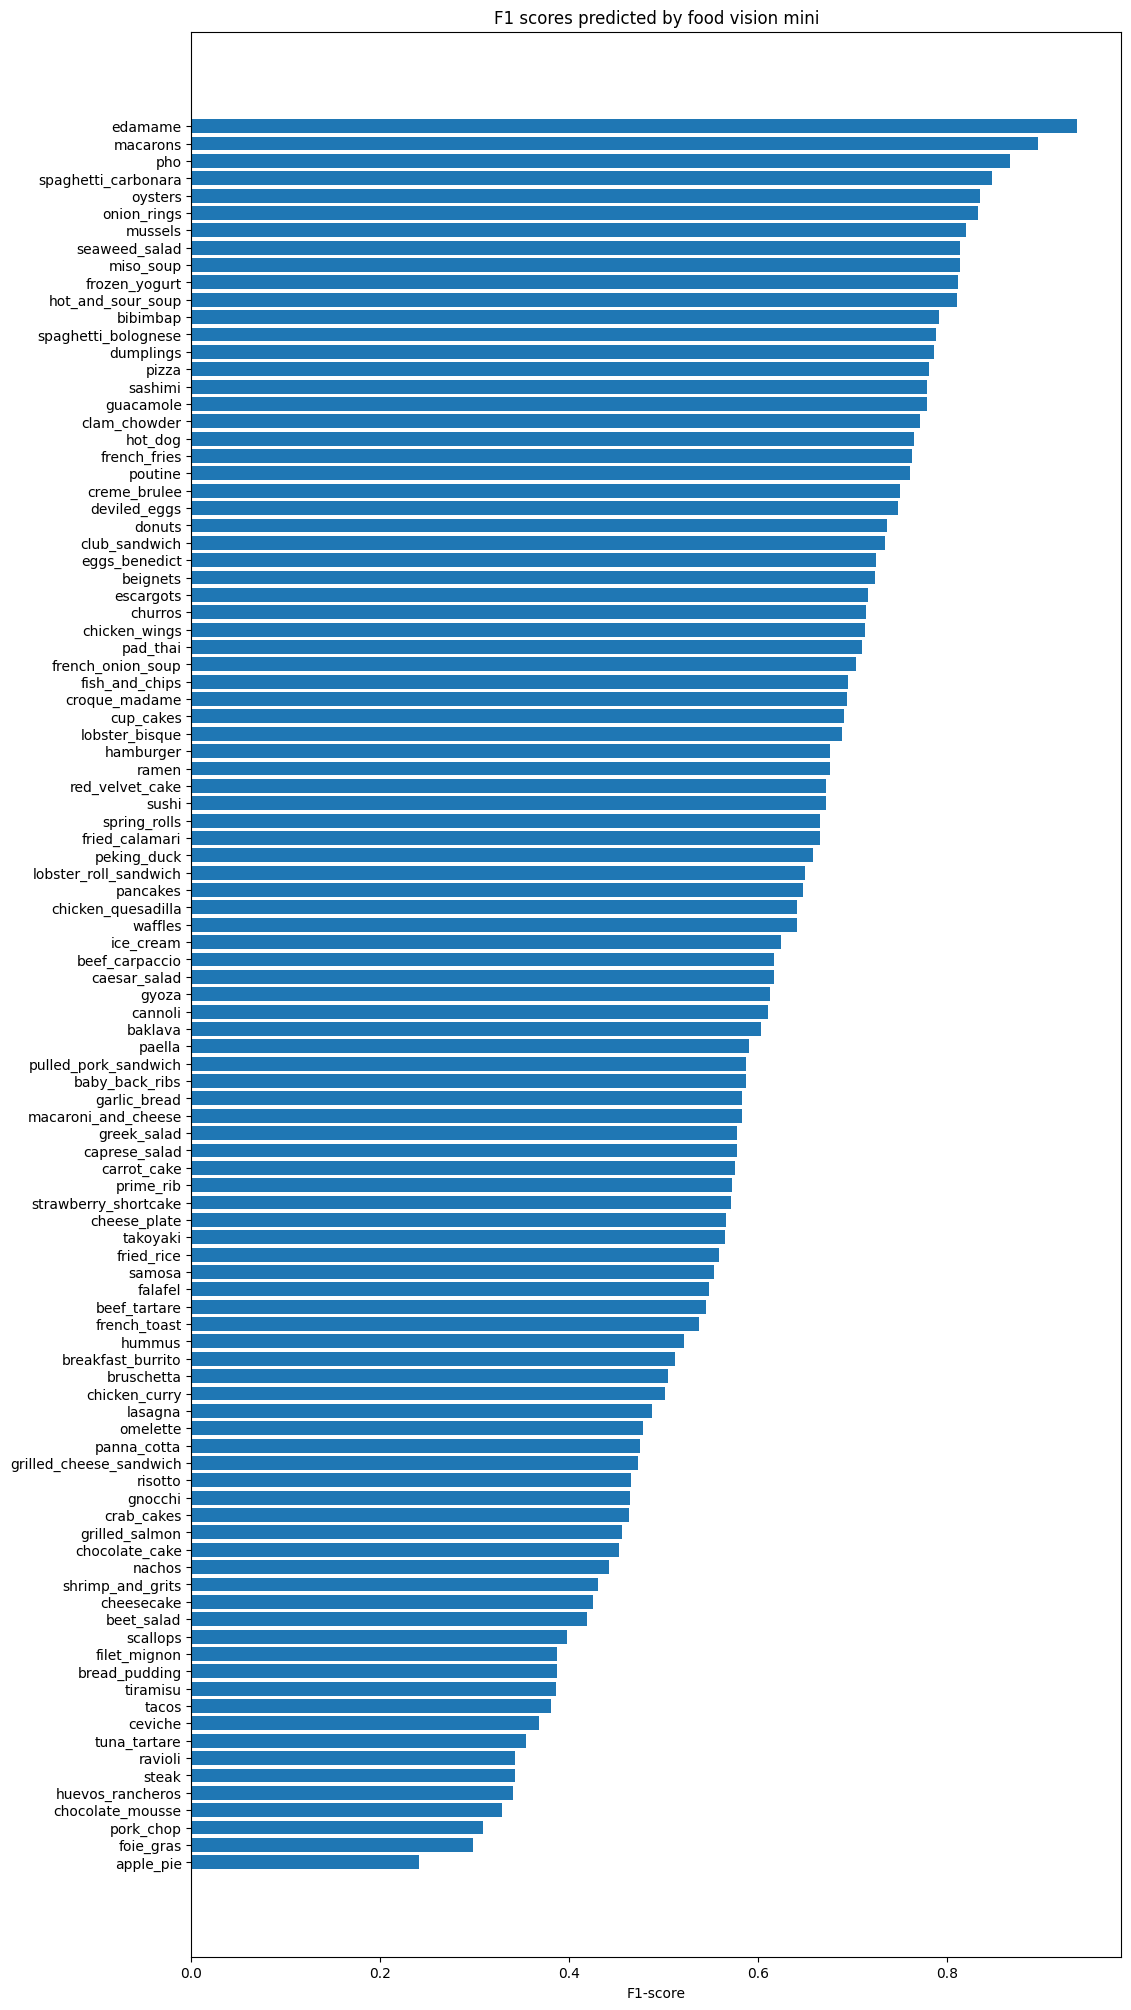

In [64]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 scores predicted by food vision mini")
ax.invert_yaxis()

In [74]:
#Visualizing predictions on custom images


def load_and_prep_image(filename, img_shape=224, scale = True):
  img = tf.io.read_file(filename=filename)

  img = tf.io.decode_image(img, channels = 3)

  img = tf.image.resize(img, size=([img_shape, img_shape]))

  if scale:
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 58ms/step


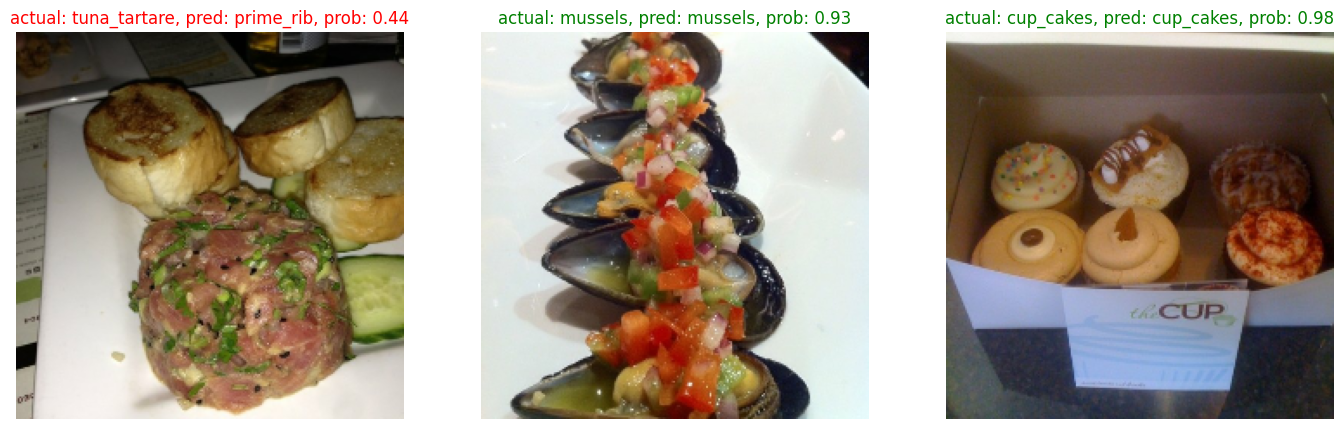

In [89]:
import os
import random

plt.figure(figsize = (17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale = False)
  img_expanded = tf.expand_dims(img, axis = 0)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c = title_color)
  plt.axis(False)

In [ ]:
#Finding the most wrong predictions

In [90]:
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle = False):
  filepaths.append(filepath.numpy())

filepaths[:10]


[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [94]:
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i]for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847418        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367903        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501947          waffles  strawberry_shortcake  
25249   0.690631          waffles               waffles  

[25250 rows x 6 columns]

In [97]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  pred_correct  
0       0.847418        apple_pie                 gyoza         False  
1       0.964017        apple_pie             apple_pie          True  
2       0.959259        apple_pie             apple_pie          True  
3       0.658607        apple_pie  pulled_pork_sandwich         False  
4       0.367903        apple_pie             prime_rib         False  
...          ...              ...                   ...           ...  
25245   0.972823          waffles               waffles          True  
25246   0.878028          waffles          cheese_plate         False  
25247   0.537899          waffles               waffles          True  
25248   0.501947          waffles  strawberry_shortcake         False  
25249   0.690631          waffles               waffles          True  

[25250 rows x 7 columns]

In [99]:
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong


img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
...                                                  ...     ...     ...   
8763   b'/content/101_food_classes_10_percent/test/es...      35      41   
2663   b'/content/101_food_classes_10_percent/test/br...      10      61   
7924   b'/content/101_food_classes_10_percent/test/do...      31      29   
18586  b'/content/101_food_classes_10_percent/test/pe...      74      39   
3519   b'/content/101_food_classes_10_percent/test/ca...      14      21   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
...          ...                    ...                    ...           ...  
8763    0.997169              escargots      french_onion_soup         False  
2663    0.997055             bruschetta  lobster_roll_sandwich         False  
7924    0.997020                 donuts              cup_cakes         False  
18586   0.996884            peking_duck              foie_gras         False  
3519    0.996842            carrot_cake         chocolate_cake         False  

[100 rows x 7 columns]

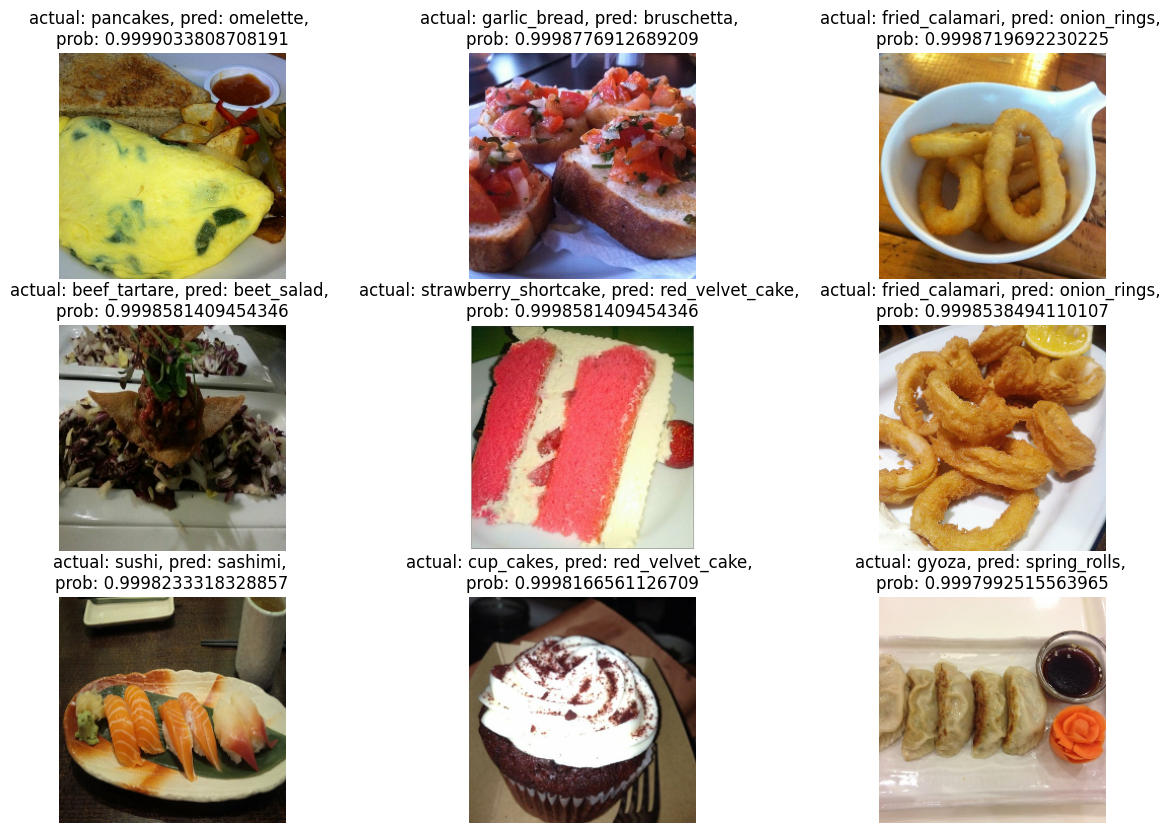

In [106]:
images_to_view = 9
start_index = 10
plt.figure(figsize =(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1], scale = False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, \nprob: {pred_prob}")
  plt.axis(False)


In [107]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")


# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

--2024-05-14 08:16:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.207, 108.177.121.207, 142.251.171.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  78.7MB/s    in 0.2s    

2024-05-14 08:16:46 (78.7 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg']

1/1 [==============================] - 0s 62ms/step


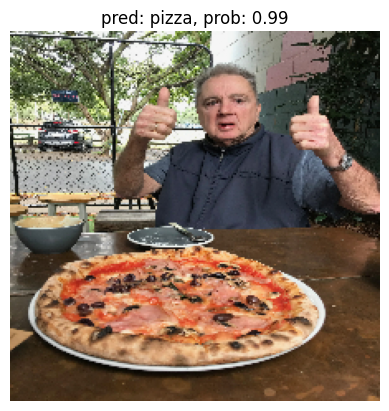

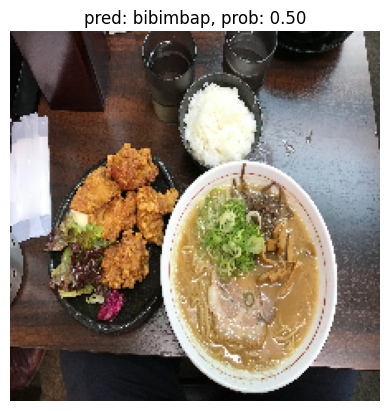

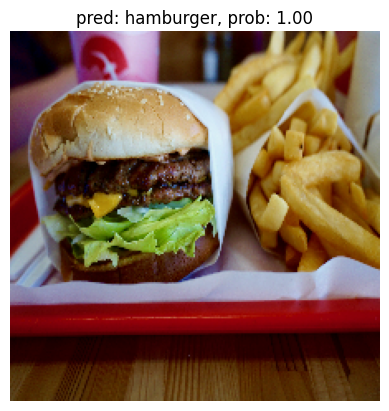

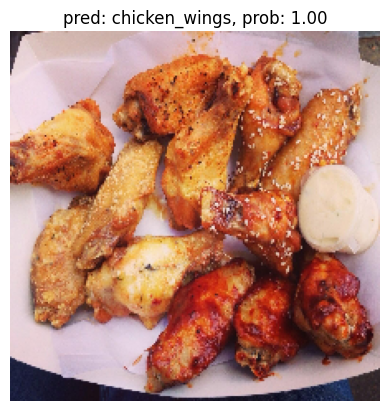

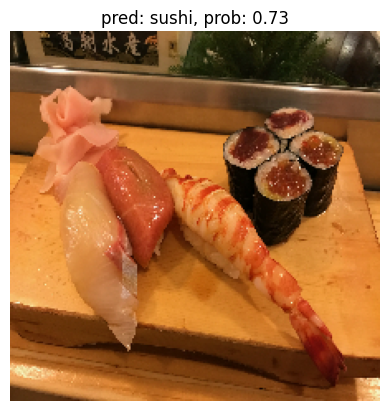

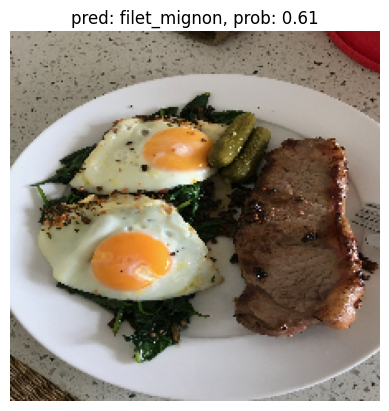

In [108]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)